# Labone Q DSL - Experiment Control for Quantum Computing

This is a companion notebook for a talk at R&S IDC 2024.

LabOne Q is open source and on [GitHub](https://github.com/zhinst/laboneq).

The user manual is [available here](https://docs.zhinst.com/labone_q_user_manual/).

Link to this page: https://t.ly/7N6nO

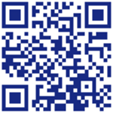

---

We start by importing Labone Q into the workspace.

In [ ]:
from laboneq.contrib.example_helpers.plotting.plot_helpers import plot_simulation
from laboneq.simple import *

from laboneq.dsl.experiment.builtins import *

# For demo's sake: get a preconfigured device setup
from laboneq.contrib.example_helpers.generate_example_datastore import (
    get_first_named_entry,
    generate_example_datastore,
)

setup_db = generate_example_datastore(in_memory=True)
setup = get_first_named_entry(
    db=setup_db, name="6_tuneable_qubit_setup_shfsg_shfqa_hdawg_pqsc_calibrated"
)

# connect to an 'emulated' device setup
session = Session(setup)
session.connect(do_emulation=True)

# Experiment definition

An experiment definition is a function tagged by `@experiment`. We also define names for the signals that the experiment will use.

The experiment definition can optionally be parametrized. Here it is not, so we instantiate the experiment by not providing any arguments.

The top level block of the experiment here is `acquire_loop_rt()`. We call it the averaging loop. 

In [2]:
@experiment(signals=["signal1"])
def exp1():
    with acquire_loop_rt(count=10):
        play("signal1", pulse=pulse_library.const(length=100e-9))
        delay("signal1", 100e-9)


my_exp = exp1()

Note that calling `play()` does not immediately trigger the playback on the instrument. So far we are just declaratively building the experiment.
We'll submit in for execution in a second.

Before we can run the experiment, we need to map the experiment signals to actual signals on our instruments. 

In [3]:
my_exp.map_signal(
    "signal1",
    setup.logical_signal_groups["q0"].logical_signals["drive_line"],
)

We can now run the experiment. The next cell first compiles the experiment to machine code, and then uploads these artifacts to the instruments. We are not connected to real instruments, but just to an emulator.

In [4]:
compiled = session.compile(my_exp)
results = session.run(compiled)

[2024.04.12 17:46:44.521] INFO    Starting LabOne Q Compiler run...
[2024.04.12 17:46:44.525] INFO    Schedule completed. [0.000 s]
[2024.04.12 17:46:44.533] INFO    Code generation completed for all AWGs. [0.006 s]
[2024.04.12 17:46:44.535] INFO    Completed compilation step 1 of 1. [0.010 s]
[2024.04.12 17:46:44.545] INFO     ───────────────────────────────────────────────────────────── 
[2024.04.12 17:46:44.546] INFO      Device    AWG   SeqC LOC   CT entries   Waveforms   Samples  
[2024.04.12 17:46:44.546] INFO     ───────────────────────────────────────────────────────────── 
[2024.04.12 17:46:44.547] INFO      shfsg_0     0         10            1           1       416  
[2024.04.12 17:46:44.548] INFO     ───────────────────────────────────────────────────────────── 
[2024.04.12 17:46:44.548] INFO      TOTAL                 10            1                   416  
[2024.04.12 17:46:44.548] INFO     ───────────────────────────────────────────────────────────── 
[2024.04.12 17:46:4

But rather than just submitting the experiment to a mock machine, we can also simulate the generated waveforms!
The output simulator is a great tool for 'debugging' DSL code. 

Let's simulate the output for the first 3 microseconds.

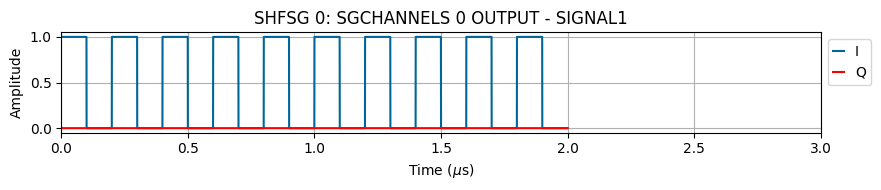

In [5]:
plot_simulation(compiled, length=3e-6)

# Parameter Sweeps

Very frequently, we need to repeat the same experiment while varying some parameter of the experiment. For example, the amplitude, phase or shape of a pulse, the length of a delay, etc.

In LabOne Q we can express a sweep as a loop over different values. Let's sweep the pulse's amplitude from 0.1 to 1.0 in 10 steps.  

In [6]:
@experiment(signals=["signal1"])
def exp2():
    my_pulse = pulse_library.const(length=100e-9)
    
    with acquire_loop_rt(5):
        
        # Note the sweep here!
        with sweep_range(start=0.1, stop=1.0, count=10) as amp:
            
            play("signal1", pulse=my_pulse, amplitude=amp)
            delay("signal1", 100e-9)


my_exp = exp2()
my_exp.map_signal(
    "signal1",
    setup.logical_signal_groups["q0"].logical_signals["drive_line"],
)

[2024.04.12 17:46:45.028] INFO    Starting LabOne Q Compiler run...
[2024.04.12 17:46:45.032] INFO    Schedule completed. [0.001 s]
[2024.04.12 17:46:45.043] INFO    Code generation completed for all AWGs. [0.011 s]
[2024.04.12 17:46:45.045] INFO    Completed compilation step 1 of 1. [0.014 s]
[2024.04.12 17:46:45.047] INFO     ───────────────────────────────────────────────────────────── 
[2024.04.12 17:46:45.048] INFO      Device    AWG   SeqC LOC   CT entries   Waveforms   Samples  
[2024.04.12 17:46:45.048] INFO     ───────────────────────────────────────────────────────────── 
[2024.04.12 17:46:45.049] INFO      shfsg_0     0         28           10           1       416  
[2024.04.12 17:46:45.050] INFO     ───────────────────────────────────────────────────────────── 
[2024.04.12 17:46:45.051] INFO      TOTAL                 28           10                   416  
[2024.04.12 17:46:45.052] INFO     ───────────────────────────────────────────────────────────── 
[2024.04.12 17:46:4

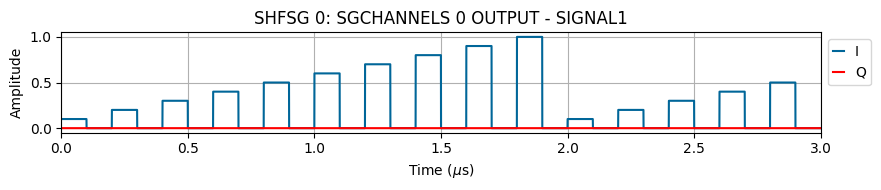

In [7]:
compiled = session.compile(my_exp)
plot_simulation(compiled, length=3e-6)

As you can see, we now fire 10 pulses of increasing amplitude. Then the outer loop (averaging loop) repeats the entire sequence4 more times. In this case we truncated the plot at 3 us for better readability. Try playing around with the sweep or averaging loop!

# Sections

Let's add another signal to the experiment: `signal2`.

Also, we'll introduce a new concept: sections. Sections are logical containers of pulses and other sections (like a curly braces block in many programming languages).

At any given level of hierarchy, sections are generally executed in parallel.  UNLESS they share signals, in which case they are scheduled sequentially.

In this example, `section1` and `section2` do not share any signals, so the are scheduled in parallel. If you uncomment the `reserve("signal1")` line, then `section2` will also touch `signal1`, and the two sections will instead be executed _sequentially_.

In [8]:
@experiment(signals=["signal1", "signal2"])
def exp3():
    my_pulse = pulse_library.const(length=100e-9)
    with acquire_loop_rt(5):
        with sweep_range(start=0.1, stop=1.0, count=10) as amp:
            with section(name="section1"):
                play("signal1", pulse=my_pulse, amplitude=amp)
                delay("signal1", 100e-9)
            with section(name="section2"):
                # uncomment to make the two sections run sequentially
                # reserve("signal1")
                play("signal2", pulse=my_pulse, length=140e-9)
                delay("signal2", 100e-9)

In [9]:
my_exp = exp3()
my_exp.map_signal(
    "signal1",
    setup.logical_signal_groups["q0"].logical_signals["drive_line"],
)
my_exp.map_signal(
    "signal2",
    setup.logical_signal_groups["q1"].logical_signals["drive_line"],
)

[2024.04.12 17:46:45.220] INFO    Starting LabOne Q Compiler run...
[2024.04.12 17:46:45.225] INFO    Schedule completed. [0.003 s]
[2024.04.12 17:46:45.241] INFO    Code generation completed for all AWGs. [0.015 s]
[2024.04.12 17:46:45.242] INFO    Completed compilation step 1 of 1. [0.019 s]
[2024.04.12 17:46:45.246] INFO     ───────────────────────────────────────────────────────────── 
[2024.04.12 17:46:45.247] INFO      Device    AWG   SeqC LOC   CT entries   Waveforms   Samples  
[2024.04.12 17:46:45.247] INFO     ───────────────────────────────────────────────────────────── 
[2024.04.12 17:46:45.248] INFO      shfsg_0     0         28           10           1       416  
[2024.04.12 17:46:45.249] INFO      shfsg_0     1         12            1           1       576  
[2024.04.12 17:46:45.250] INFO     ───────────────────────────────────────────────────────────── 
[2024.04.12 17:46:45.251] INFO      TOTAL                 40           11                   992  
[2024.04.12 17:46:4

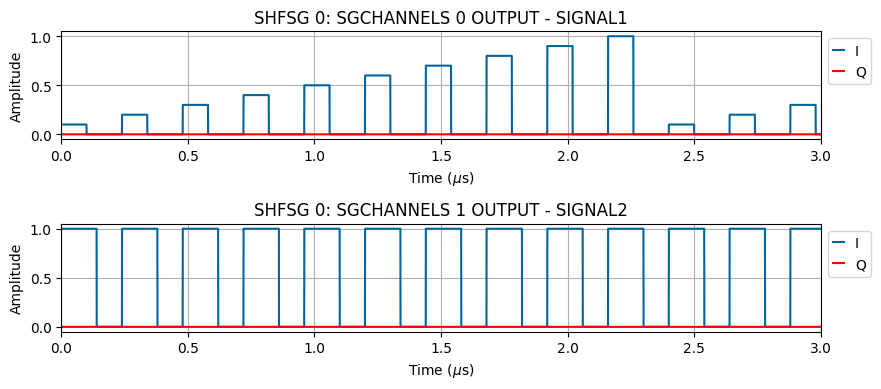

In [10]:
compiled = session.compile(my_exp)
plot_simulation(compiled, length=3e-6)

# Rabi experiment

We are now ready to for a simple but real-world example! This is what physicists call an 'amplitude Rabi' experiment. It serves to accurately calibrate the amplitude of a pulse for flipping a qubit's state. 

[2024.04.12 17:47:20.408] INFO    Starting LabOne Q Compiler run...
[2024.04.12 17:47:20.414] INFO    Schedule completed. [0.003 s]
[2024.04.12 17:47:20.440] INFO    Code generation completed for all AWGs. [0.025 s]
[2024.04.12 17:47:20.441] INFO    Completed compilation step 1 of 1. [0.030 s]
[2024.04.12 17:47:20.446] INFO     ───────────────────────────────────────────────────────────── 
[2024.04.12 17:47:20.447] INFO      Device    AWG   SeqC LOC   CT entries   Waveforms   Samples  
[2024.04.12 17:47:20.448] INFO     ───────────────────────────────────────────────────────────── 
[2024.04.12 17:47:20.449] INFO      shfqa_0     0         10            0           1      1600  
[2024.04.12 17:47:20.450] INFO      shfsg_0     0         30           11           1       192  
[2024.04.12 17:47:20.450] INFO     ───────────────────────────────────────────────────────────── 
[2024.04.12 17:47:20.451] INFO      TOTAL                 40           11                  1792  
[2024.04.12 17:47:2

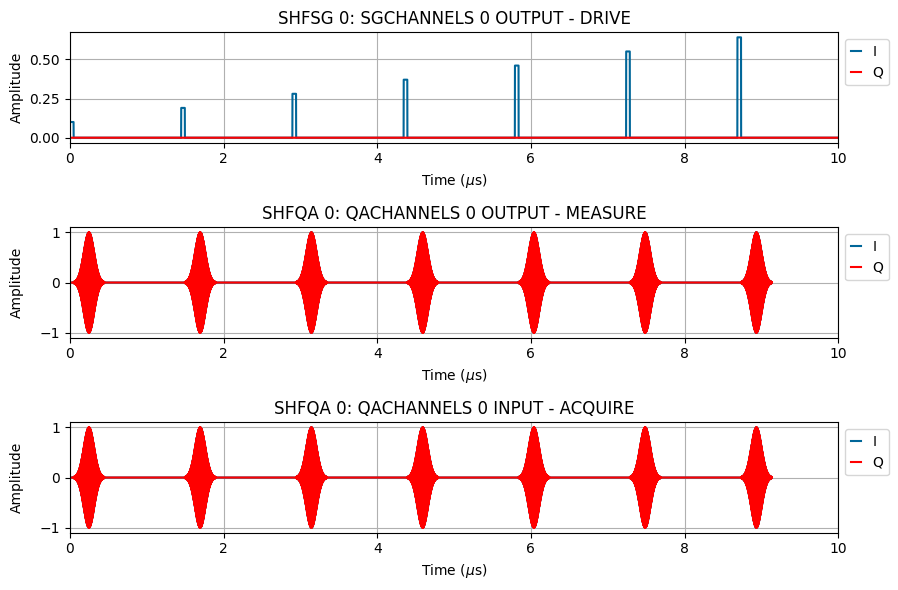

In [16]:
drive_pulse = pulse_library.const(uid="drive_pulse", length=48e-9)
measure_pulse = pulse_library.gaussian(uid="measure_pulse", length=400e-9)
readout_weights = pulse_library.gaussian(uid="readout_weights", length=400e-9)


@experiment(signals=["drive", "measure", "acquire"])
def rabi_exp():
    with acquire_loop_rt(16):
        with sweep_range(start=0.1, stop=1.0, count=11) as amp:
            with section(name="qubit_excitation"):
                play("drive", drive_pulse, amplitude=amp)
            with section(name="readout"):
                reserve("drive")
                play("measure", measure_pulse)
                acquire("acquire", kernel=readout_weights, handle="h1")
            with section(name="relaxation"):
                delay("drive", 1e-6)

    q0_lsg = setup.logical_signal_groups["q0"].logical_signals
    map_signal("drive", q0_lsg["drive_line"])
    map_signal("measure", q0_lsg["measure_line"])
    map_signal("acquire", q0_lsg["acquire_line"])


rabi_compiled = session.compile(rabi_exp())
plot_simulation(rabi_compiled, length=10e-6)

# Pulse sheet viewer

Sometimes it can be difficult to tell from the waveform output alone why the the compiler laid out the pulses in the way it did. We offer another helpful tool, the _Pulse Sheet Viewer_, which offers a more abstract view of the sequence, one that in particular also shows the sections.

*Note*: In MyBinder, we can't unfortunately not embed the HTML directly into the notebook. Instead, we create a HTML file. Click the generated link, and click 'Trust HTML'.

In [ ]:
show_pulse_sheet("pulse_sheet_example", rabi_compiled, max_events_to_publish=1_000_000)

# Active qubit reset

Let us look at a more complex feature, that demonstrates the power of the abstractions provided by LabOne Q.

To initialize a qubit in the zero state, one way is to first measure its current state, and flip it if it's not already as desired. This process is called active reset.

In LabOne Q, we model this with `match...case` blocks. 

In [13]:
@experiment(signals=["drive", "measure", "acquire"])
def exp_active_reset():
    q0_lsg = setup.logical_signal_groups["q0"].logical_signals
    map_signal("drive", q0_lsg["drive_line"])
    map_signal("measure", q0_lsg["measure_line"])
    map_signal("acquire", q0_lsg["acquire_line"])

    with acquire_loop_rt(1):
        with section(name="reset"):
            with section(name="readout"):
                play("measure", measure_pulse)
                acquire("acquire", handle="h1", kernel=readout_weights)

            with match("h1", name="conditional_flip"):
                with case(0):
                    pass
                with case(1):
                    play("drive", drive_pulse)

        # qubit is now initialized to the ground state
        # main body of experiment would go here
        ...

In [ ]:
active_reset_compiled = session.compile(exp_active_reset())

In [ ]:
show_pulse_sheet("", active_reset_compiled)

Note how the compiler delayed the playback of the pulse to account for the latency of analyzing and transmitting the information across instruments. 